In [1]:
import os
import glob
import pandas as pd
from pathlib import Path
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
import pydotplus

from scipy import stats
from statistics import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from six import StringIO
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from IPython.display import Image  
from sklearn.tree import export_graphviz

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_excel("Technical test sample data.ods", engine="odf")
selected_columns = ['has_gender', 'has_first_name',
       'has_last_name', 'has_email', 'has_dob', 'account_age',
       'account_last_updated', 'app_downloads',
       'unique_offer_clicked', 'total_offer_clicks', 'unique_offer_rides',
       'total_offer_rides', 'avg_claims', 'min_claims', 'max_claims',
       'total_offers_claimed']

train_df = df[selected_columns]

### Choosing Ideal K slection using Elbow Criterion

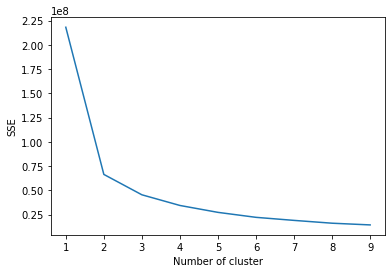

In [3]:
sse = {}
temp_df = train_df
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(temp_df)
    temp_df["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Cluster Visualization

PCA component Explained variance ratio -  [0.79175421 0.2068606 ]
PCA component Explained variance -  [17274.79807599  4513.36414524]


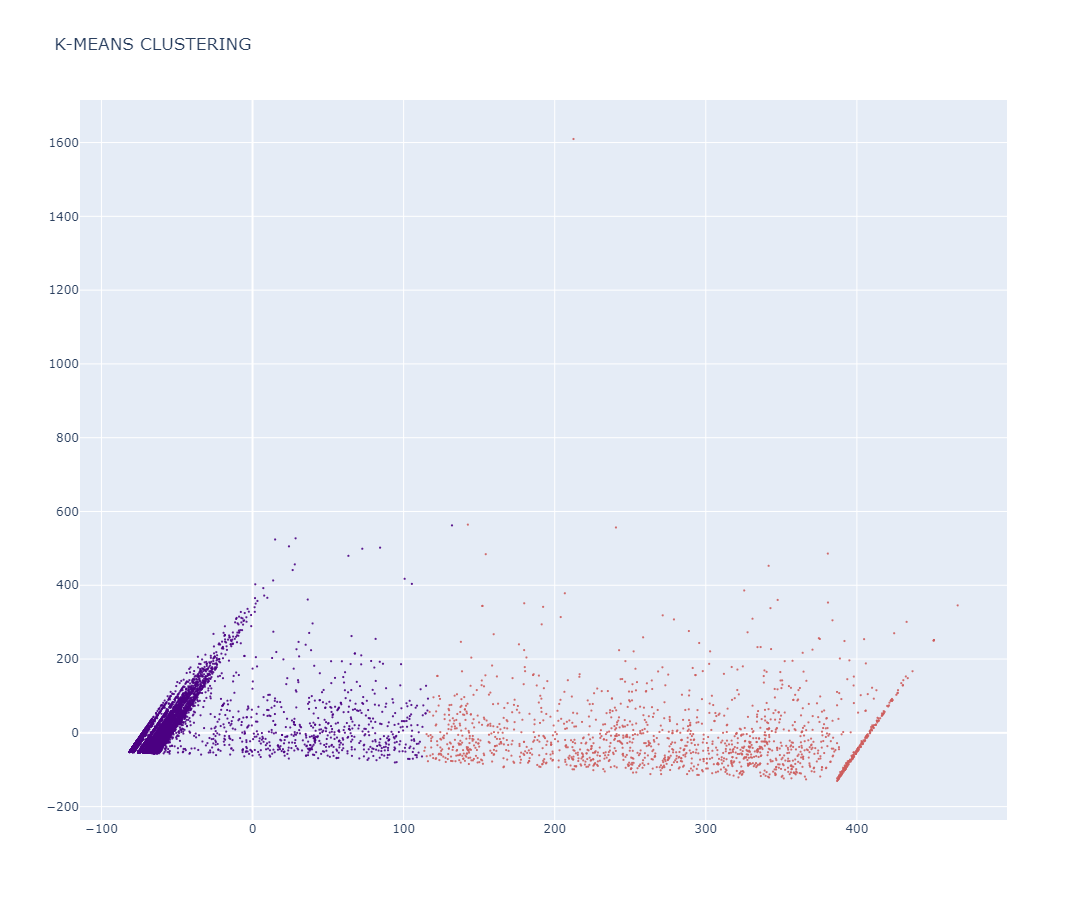

In [4]:
temp_df = train_df
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(temp_df)
temp_df["cluster"] = kmeans.labels_

pca = PCA(n_components=2)
pca.fit(temp_df)
print("PCA component Explained variance ratio - ", pca.explained_variance_ratio_)
print("PCA component Explained variance - ", pca.explained_variance_)

pca_transform = pca.transform(temp_df)
pca_transform_df = pd.DataFrame(pca_transform).loc[:,:2]
pca_transform_df.index = temp_df.index
pca_transform_df.columns = ['PC1','PC2']


trace1 = go.Scatter(
    x=pca_transform_df["PC1"],
    y=pca_transform_df["PC2"],
    mode='markers',
    text=temp_df["cluster"],
    marker=dict(
        size=2,
        color=train_df["cluster"],
        colorscale=[[0.0,"indianred"],[0.2,"darkorange"],[0.4,"yellow"],[0.6,"mediumseagreen"],[0.8,"skyblue"],[1.0, "indigo"]],
        opacity=0.9
    )
)
data = [trace1]
layout = go.Layout(
    showlegend=False,
    title="K-MEANS CLUSTERING",
    scene = dict(
        xaxis = dict(title="PC1"),
        yaxis = dict(title="PC2"),
#         zaxis = dict(title="PC3")
    ),
    width=1000,
    height=900
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

### Random Forest Feature Importance Plot

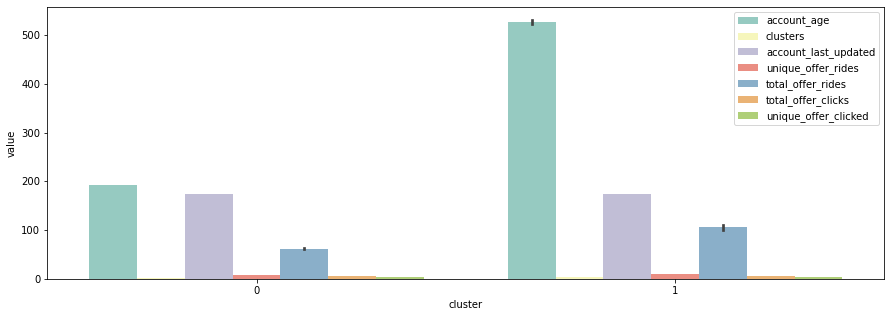

In [5]:
temp_df = train_df

kmeans = KMeans(n_clusters=2,random_state=42)
kmeans.fit(temp_df)
temp_df['cluster'] = kmeans.predict(temp_df)


y = temp_df.iloc[:,-1]
X = temp_df.iloc[:,:-1]

clf = RandomForestClassifier(n_estimators=100).fit(X, y)
selected_columns_ = list(pd.DataFrame(np.array([clf.feature_importances_, X.columns]).T, columns=['Importance', 'Feature'])
           .sort_values("Importance", ascending=False)
           .head(7)
           .Feature
           .values)

tidy = temp_df[selected_columns_+['cluster']].melt(id_vars='cluster')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='cluster', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')

### Decision Tree visualization

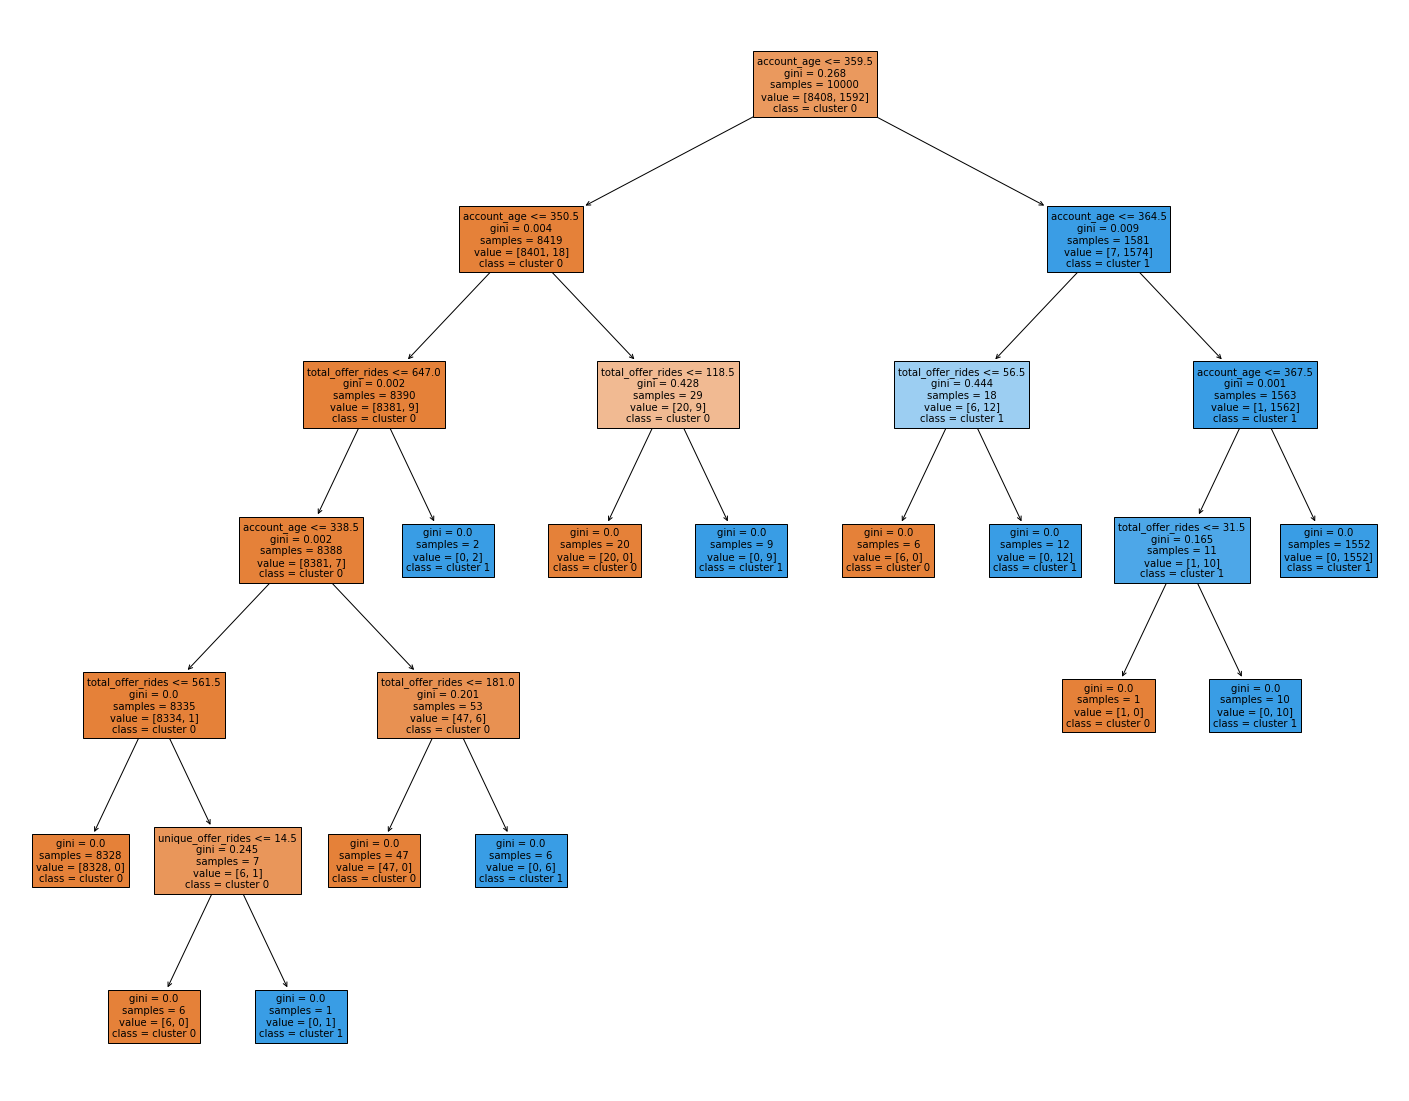

In [6]:
temp_df = train_df

y = temp_df.iloc[:,-1]
X = temp_df.iloc[:,:-1]

clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X, y)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns.to_list(),  
                   class_names=["cluster 0", "cluster 1"],
                   filled=True)